In [1]:
%matplotlib inline

import pymongo
import seaborn as sns

In [2]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [3]:
client = pymongo.MongoClient()
db = client.metrics

cb_td, cb_vd, sc_td, sc_vd = "CB_TAGGING_TD_FEAT_SELECTION", "CB_TAGGING_VD_FEAT_SELECTION", "SC_TAGGING_TD_FEAT_SELECTION", "SC_TAGGING_VD_FEAT_SELECTION"
cb_td, cb_vd, sc_td, sc_vd = db[cb_td], db[cb_vd], db[sc_td], db[sc_vd]
cb_td, cb_vd, sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'CB_TAGGING_VD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'metrics'), u'SC_TAGGING_VD_FEAT_SELECTION'))

# Query Top Features

In [4]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            "window_size":    "$parameters.window_size",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

In [5]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(10)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,weighted_f1_score,window_size,hs_feats
0,58906dbdc1a7cbe6d8cc8020,2017-01-31 04:58:05.840,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.824667,0.886629,0.770799,0.818123,9,extract_brown_cluster|extract_dependency_relat...
1,589042fac1a7cbe6d8cc7fa2,2017-01-31 01:55:38.411,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.824443,0.886471,0.770528,0.817820,11,extract_brown_cluster|extract_dependency_relat...
2,589069c3c1a7cbe6d8cc8018,2017-01-31 04:41:07.397,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.824233,0.885508,0.770889,0.817698,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
3,58903da2c1a7cbe6d8cc7f9c,2017-01-31 01:32:50.254,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.824036,0.885133,0.770829,0.817427,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
4,589070abc1a7cbe6d8cc8026,2017-01-31 05:10:35.909,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.824012,0.885991,0.770137,0.817493,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
5,58906ab1c1a7cbe6d8cc801a,2017-01-31 04:45:05.280,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.823907,0.884718,0.770919,0.817533,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
6,58906eb3c1a7cbe6d8cc8022,2017-01-31 05:02:11.826,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.823821,0.885867,0.769897,0.817342,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
7,589044abc1a7cbe6d8cc7fa4,2017-01-31 02:02:51.020,6,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.823763,0.887170,0.768814,0.816944,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
8,58903bfec1a7cbe6d8cc7f9a,2017-01-31 01:25:50.259,5,"[fn_pos_wd_feats_stemmed[offset:5], fn_pos_ngr...",0.823738,0.885794,0.769807,0.817008,11,extract_brown_cluster|fn_bow_ngram_feat[ngram_...
9,58905e42c1a7cbe6d8cc7ffc,2017-01-31 03:52:02.503,4,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.823567,0.884369,0.770588,0.816908,9,extract_brown_cluster|fn_bow_ngram_feat[ngram_...


In [7]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2017-01-30T21:19:41.374000000'),
 numpy.datetime64('2017-01-31T09:53:30.519000000'))

In [8]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision,window_size".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, win_size = 11):
    df_top_individual_feats = df[(df["count"] == 1) & (df["window_size"] == win_size)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, 11)

In [9]:
a, b = get_top_individual_feats(cb_vd_df, 11), get_top_individual_feats(sc_vd_df, 11)
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC".split(",")]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC
0,1,pos_wd_feats_stemmed[],0.813492,0.748700,0.890562,pos_wd_feats_stemmed[],0.792558,0.741854,0.850700
1,2,pos_wd_feats[],0.805808,0.735049,0.891641,pos_wd_feats[],0.790039,0.735110,0.853841
2,3,pos_ngram_feat_stemmed[ngram_size:2],0.771511,0.669142,0.910858,pos_ngram_feat_stemmed[ngram_size:2],0.762688,0.678501,0.870726
3,4,pos_ngram_feat[ngram_size:2],0.755086,0.645600,0.909291,pos_ngram_feat[ngram_size:2],0.755356,0.667897,0.869170
4,5,pos_ngram_feat_stemmed[ngram_size:3],0.707099,0.572627,0.924111,pos_ngram_feat_stemmed[ngram_size:3],0.699760,0.581356,0.878728
5,6,pos_ngram_feat[ngram_size:3],0.682357,0.541327,0.922762,pos_ngram_feat[ngram_size:3],0.687137,0.565820,0.874676
6,7,bow_ngram_feat[ngram_size:2],0.565426,0.446676,0.770180,extract_dependency_relation,0.572233,0.467266,0.738022
7,8,extract_dependency_relation,0.557585,0.412971,0.858062,bow_ngram_feat[ngram_size:2],0.542433,0.431529,0.730060
8,9,bow_ngram_feat[ngram_size:1],0.555793,0.465528,0.689482,bow_ngram_feat[ngram_size:3],0.517383,0.383511,0.794840
9,10,bow_ngram_feat[ngram_size:3],0.520155,0.381190,0.818569,bow_ngram_feat[ngram_size:1],0.504963,0.411396,0.653623


## Generate Rows for LaTex Table

In [10]:
def format_lbl(lbl):
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & pos wd feats stemmed & 0.813 & & pos wd feats stemmed & 0.793\\
2 & pos wd feats & 0.806 & & pos wd feats & 0.790\\
3 & pos ngram feat stemmed ngram size:2 & 0.772 & & pos ngram feat stemmed ngram size:2 & 0.763\\
4 & pos ngram feat ngram size:2 & 0.755 & & pos ngram feat ngram size:2 & 0.755\\
5 & pos ngram feat stemmed ngram size:3 & 0.707 & & pos ngram feat stemmed ngram size:3 & 0.700\\
6 & pos ngram feat ngram size:3 & 0.682 & & pos ngram feat ngram size:3 & 0.687\\
7 & bow ngram feat ngram size:2 & 0.565 & & extract dependency relation & 0.572\\
8 & extract dependency relation & 0.558 & & bow ngram feat ngram size:2 & 0.542\\
9 & bow ngram feat ngram size:1 & 0.556 & & bow ngram feat ngram size:3 & 0.517\\
10 & bow ngram feat ngram size:3 & 0.520 & & bow ngram feat ngram size:1 & 0.505\\
11 & extract brown cluster & 0.360 & & pos POS feats & 0.374\\
12 & pos POS feats & 0.237 & & extract brown cluster & 0.324\\
13 & bow POS feats & 0.058 & & bow POS feats & 0.072\\


## Perfomance By Window Size

In [11]:
def get_by_window_size(df):
    return group_by(df, bycols=["window_size"], agg_map=[("micro_f1_score", "max"),
                                              #("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("window_size")

by_win_size = pd.merge(get_by_window_size(cb_vd_df), get_by_window_size(sc_vd_df), on="window_size", suffixes=["_CB", "_SC"])
by_win_size

,window_size,max(micro_f1_score)_CB,max(micro_f1_score)_SC
0,9,0.824667,0.801090
1,11,0.824443,0.800888
2,13,0.822428,0.799787


## Plot TD vs VD F1 Score For CB By Window Size

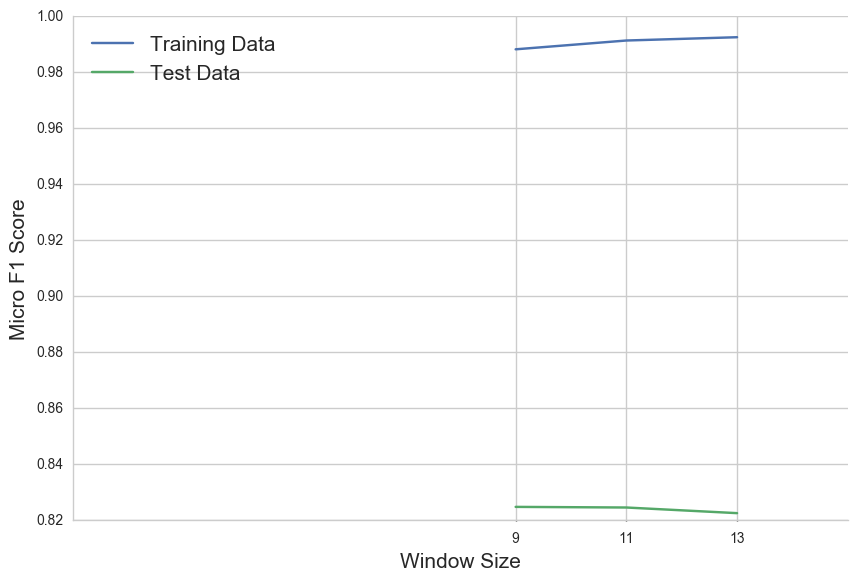

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = pd.merge(
    get_by_window_size(cb_td_df), 
    get_by_window_size(cb_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+2, 2.0), fontsize=10)
plt.yticks(fontsize=10)

sns.despine()
plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/cb_f1_vs_win_size.png")
plt.show()

## Plot TD vs VD F1 Score For SC By Window Size

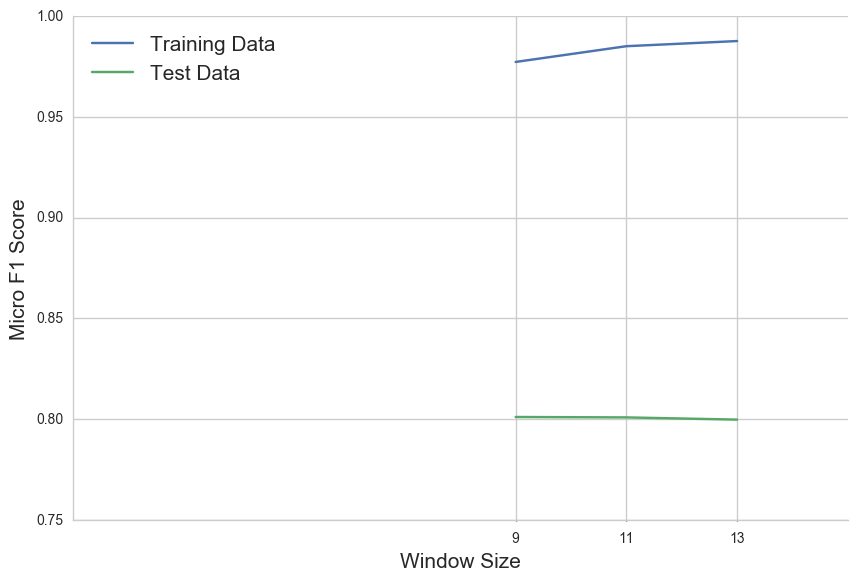

In [13]:
FONT_SIZE = 15

df = pd.merge(
    get_by_window_size(sc_td_df), 
    get_by_window_size(sc_vd_df), 
    on="window_size", suffixes=["_TD", "_VD"])

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(10,6.5))

x = df["window_size"].values
y_td = df["max(micro_f1_score)_TD"].values
y_vd = df["max(micro_f1_score)_VD"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_td, label="Training Data")
ax1.plot(x,y_vd, label="Test Data")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 15])
#ax1.set_ylim([0.7, 0.85])
ax1.set_xlabel('Window Size', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+2, 2.0), fontsize=10)
plt.yticks(fontsize=10)

sns.despine()
plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/sc_f1_vs_win_size.png")
plt.show()

## Performance By Feature Set Size

In [15]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,mean(micro_f1_score)_cb,max(micro_f1_score)_sc,mean(micro_f1_score)_sc
0,1,0.813492,0.568819,0.792558,0.569163
1,2,0.819141,0.811474,0.799118,0.792389
2,3,0.822749,0.815353,0.800872,0.795983
3,4,0.823567,0.819360,0.801090,0.797529
4,5,0.824233,0.821355,0.800949,0.799416
5,6,0.824667,0.821661,0.800888,0.799783


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [27]:
cols_filter = "count,new_feat,micro_f1_score,micro_recall,micro_precision".split(",")

def get_f1_by_feat_count(df):
    top_feats = df.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]

    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

,count,new_feat_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,new_feat_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC
0,1,pos_wd_feats_stemmed[offset:4],0.812696,0.746745,0.891425,pos_wd_feats_stemmed[offset:4],0.791081,0.739942,0.849815
1,2,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.819141,0.752458,0.898793,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.799118,0.747861,0.857918
2,3,bow_ngram_feat[ngram_size:1offset:4],0.822749,0.768574,0.885141,extract_brown_cluster,0.800872,0.751653,0.856990
3,4,extract_brown_cluster,0.823567,0.770588,0.884369,bow_ngram_feat[ngram_size:1offset:4],0.801090,0.759236,0.847829
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.824233,0.770889,0.885508,NaN,NaN,NaN,NaN
5,6,extract_dependency_relation,0.824667,0.770799,0.886629,NaN,NaN,NaN,NaN


In [23]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))  
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
df

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,pos_wd_feats_stemmed[],0.8172,pos_wd_feats_stemmed[],0.7991
1,2,pos_ngram_feat_stemmed[ngram_size:3],0.8229,pos_ngram_feat_stemmed[ngram_size:2],0.8041
2,3,bow_ngram_feat[ngram_size:1],0.8245,bow_ngram_feat[ngram_size:1],0.8065
3,4,pos_ngram_feat_stemmed[ngram_size:2],0.8270,extract_dependency_relation,0.8068
4,5,extract_brown_cluster,0.8276,extract_brown_cluster,0.8071
5,6,extract_dependency_relation,0.8283,pos_ngram_feat_stemmed[ngram_size:3],0.8073


# Plot F1 Score Against # Feature Sets

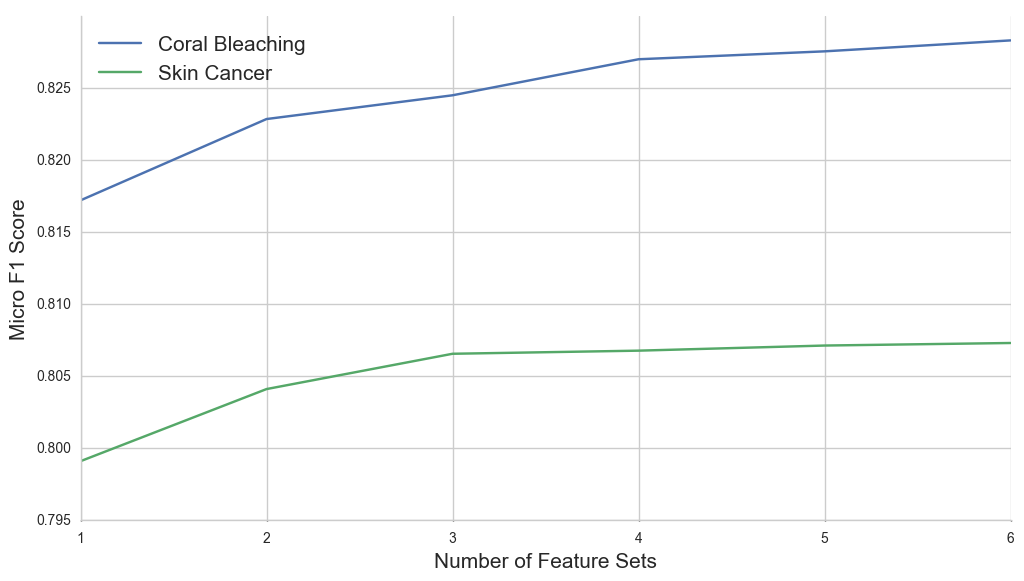

In [16]:
FONT_SIZE = 15

df = df_f1_score_by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 6])
ax1.set_ylim([0.795, 0.83])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

In [17]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["new_feat_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1:0.4f}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & pos wd feats stemmed & 0.8172 & & pos wd feats stemmed & 0.7991\\
2 & pos ngram feat stemmed ngram size:3 & 0.8229 & & pos ngram feat stemmed ngram size:2 & 0.8041\\
3 & bow ngram feat ngram size:1 & 0.8245 & & bow ngram feat ngram size:1 & 0.8065\\
4 & pos ngram feat stemmed ngram size:2 & 0.8270 & & extract dependency relation & 0.8068\\
5 & extract brown cluster & 0.8276 & & extract brown cluster & 0.8071\\
6 & extract dependency relation & 0.8283 & & pos ngram feat stemmed ngram size:3 & 0.8073\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [17]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"